<a href="https://colab.research.google.com/github/Hend-Khaled-Aly/ITI_NLP/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
from datasets import load_dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
dataset = load_dataset("imdb")

train_data = dataset["train"]
test_data = dataset["test"]

print(f"Training: {len(train_data)}")
print(f"review: {train_data[0]['text'][:100]}...")
print(f"label: {train_data[0]['label']}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training: 25000
review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
label: 0


In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

train_reviews = []
train_labels = []

for sample in tqdm(train_data):
    label_int = sample['label']
    train_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

print(f"Example tokenized review: {train_reviews[0][:15]}...")
print(f"Example tokenized label: {train_labels[0]}...")


100%|██████████| 25000/25000 [00:20<00:00, 1241.80it/s]

Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Example tokenized label: 0...


In [6]:
def build_vocab(reviews, max_words=10000):
    word_count = Counter()
    for review in reviews:
        word_count.update(review)

    most_common = word_count.most_common(max_words - 2)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}

    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab


In [7]:
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)

print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}


Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


In [8]:
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


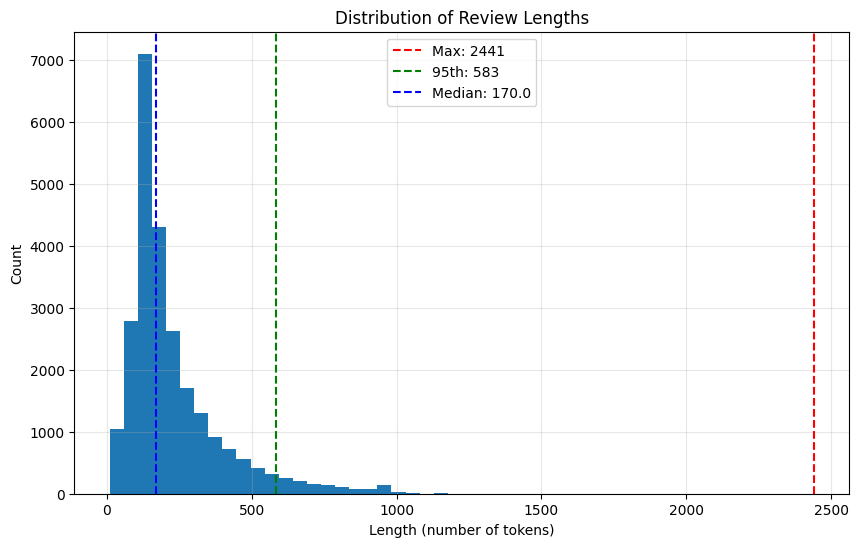

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_review(review, vocab, max_len=None):
    if max_len is None:
        max_len = chosen_max_len

    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

Chosen max_len: 583


In [11]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


100%|██████████| 25000/25000 [00:02<00:00, 8708.91it/s] 


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [12]:
def encode_review(review, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded


In [13]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Data encoding complete! Example sequence: {train_sequences[0][:15]}...")


100%|██████████| 25000/25000 [00:01<00:00, 14055.94it/s]


Data encoding complete! Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [14]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [15]:
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")


DataLoaders created! Training batches: 352


In [16]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim,
                        hidden_dim,
                        num_layers=n_layers,
                        bidirectional=False,
                        dropout=dropout if n_layers > 1 else 0,
                        batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)


In [17]:
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2

model = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model created and moved to {device}!")
print(model)

Model created and moved to cuda!
SentimentLSTM(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(iterator, desc="Training"):
        text, labels = batch
        text, labels = text.to(device), labels.float().to(device)
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float()
        accuracy = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [20]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            text, labels = batch
            text, labels = text.to(device), labels.float().to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float()
            accuracy = correct.sum() / len(correct)
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [21]:
n_epochs = 2
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("\nTraining complete!")


Epoch 1/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 83.76it/s]


Train Loss: 0.6933 | Train Acc: 50.82%
Val Loss: 0.6944 | Val Acc: 48.79%

Epoch 2/2
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 81.57it/s]

Train Loss: 0.6930 | Train Acc: 51.51%
Val Loss: 0.6807 | Val Acc: 58.32%

Training complete!


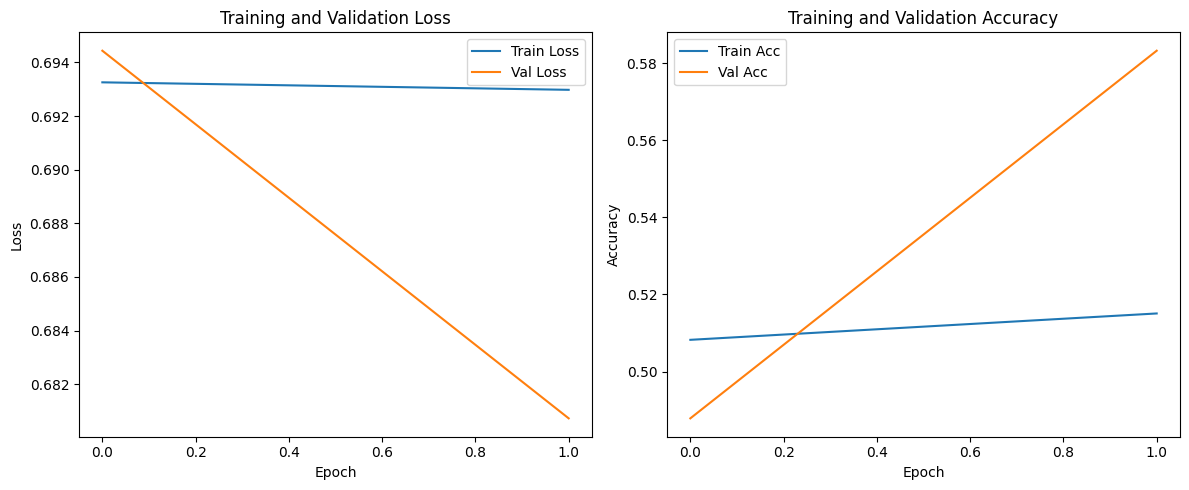

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:04<00:00, 78.51it/s]

Test Loss: 0.6844 | Test Acc: 56.84%


In [24]:
def predict_sentiment(model, text, vocab, max_len=200):
    tokens = preprocess_text(text)
    encoded = encode_review(tokens, vocab, max_len)
    tensor = torch.tensor(encoded).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))

    probability = prediction.item()
    sentiment = "Positive" if probability >= 0.5 else "Negative"

    return probability, sentiment

sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances."
]

print("Model predictions on sample reviews:")
for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)


Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Positive (probability: 0.5487)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Negative (probability: 0.4395)
--------------------------------------------------


In [25]:
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'model_params': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'n_layers': n_layers
    }
}, 'lstm_sentiment_model.pt')

print("Model saved successfully!")

Model saved successfully!


Task :
- train a 1/3 layered network and compare the results
- change the task from many to one to many to many tasK

**1. Stacked layered network with bidirectional LSTM**

In [26]:
dataset = load_dataset("imdb")

train_data = dataset["train"]
test_data = dataset["test"]

print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")

Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [27]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens


In [28]:
train_reviews = []
train_labels = []

for sample in tqdm(train_data):
    label_int = sample['label']
    train_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

print(f"Example tokenized review: {train_reviews[0][:15]}...")
print(f"Example tokenized label: {train_labels[0]}...")


100%|██████████| 25000/25000 [00:20<00:00, 1239.84it/s]

Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Example tokenized label: 0...


In [29]:
def build_vocab(reviews, max_words=10000):
    word_count = Counter()
    for review in reviews:
        word_count.update(review)
    most_common = word_count.most_common(max_words - 2)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab

In [30]:
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)
print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")
idx_to_word = {idx: word for word, idx in vocab.items()}

Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


In [31]:
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


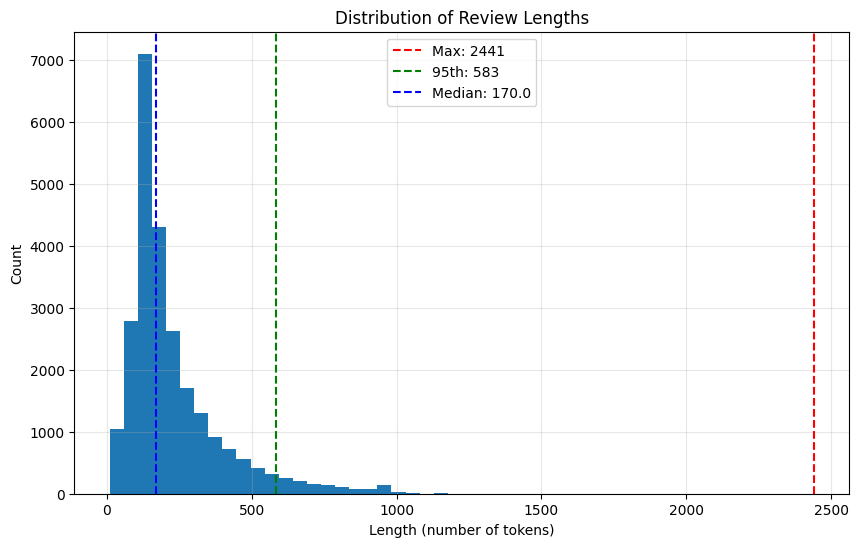

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [33]:
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

Chosen max_len: 583


In [34]:
def encode_review(review, vocab, max_len=None):
    if max_len is None:
        max_len = chosen_max_len

    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

In [35]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


100%|██████████| 25000/25000 [00:01<00:00, 15088.49it/s]


Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [36]:
def encode_review(review, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

In [37]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Example sequence: {train_sequences[0][:15]}...")


100%|██████████| 25000/25000 [00:01<00:00, 21541.17it/s]


Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [38]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [39]:
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training batches: {len(train_loader)}")

Training batches: 352


In [40]:
class StackedBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(StackedBiLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            dropout=dropout if n_layers > 1 else 0,
                            bidirectional=True,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, _ = self.lstm(embedded)
        final_hidden = self.dropout(outputs[:, -1, :])
        return self.fc(final_hidden)


In [41]:
model = StackedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers
).to(device)

In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
n_epochs = 10

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")



Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.19it/s]


Train Loss: 0.6947 | Train Acc: 50.53%
Val Loss: 0.6932 | Val Acc: 51.09%

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Train Loss: 0.6927 | Train Acc: 50.80%
Val Loss: 0.6948 | Val Acc: 48.71%

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 36.13it/s]


Train Loss: 0.6911 | Train Acc: 51.97%
Val Loss: 0.6940 | Val Acc: 49.73%

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.80it/s]


Train Loss: 0.6916 | Train Acc: 51.26%
Val Loss: 0.6831 | Val Acc: 52.97%

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.64it/s]


Train Loss: 0.6661 | Train Acc: 59.11%
Val Loss: 0.6005 | Val Acc: 69.84%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.77it/s]


Train Loss: 0.5670 | Train Acc: 72.31%
Val Loss: 0.4997 | Val Acc: 76.25%

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.90it/s]


Train Loss: 0.5561 | Train Acc: 73.36%
Val Loss: 0.5154 | Val Acc: 75.70%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.45it/s]


Train Loss: 0.4797 | Train Acc: 78.20%
Val Loss: 0.4457 | Val Acc: 78.28%

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.86it/s]


Train Loss: 0.4351 | Train Acc: 80.35%
Val Loss: 0.4304 | Val Acc: 80.43%

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.76it/s]

Train Loss: 0.4064 | Train Acc: 82.10%
Val Loss: 0.4195 | Val Acc: 81.48%


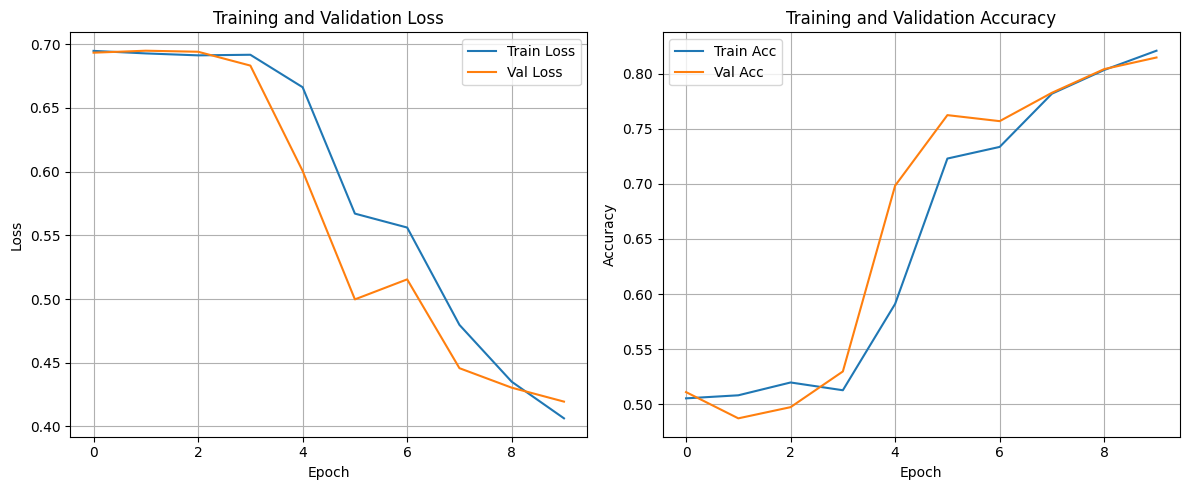

In [46]:
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [47]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:11<00:00, 35.17it/s]

Test Loss: 0.4220 | Test Acc: 81.88%


In [48]:
sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances."
]

print("Model predictions on sample reviews:")
for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)

Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.7789)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Negative (probability: 0.0747)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Negative (probability: 0.2505)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Positive (probability: 0.8587)
--------------------------------------------------


**2. Stacked layered network without bidirectional LSTM**

In [49]:
dataset = load_dataset("imdb")

train_data = dataset["train"]
test_data = dataset["test"]

print(f"Dataset loaded! Total training examples: {len(train_data)}")
print(f"Sample review (text): {train_data[0]['text'][:100]}...")
print(f"Sample label (0=negative, 1=positive): {train_data[0]['label']}")

Dataset loaded! Total training examples: 25000
Sample review (text): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Sample label (0=negative, 1=positive): 0


In [50]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

In [51]:
train_reviews = []
train_labels = []

for sample in tqdm(train_data):
    label_int = sample['label']
    train_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    train_reviews.append(tokens)

test_reviews = []
test_labels = []

for sample in tqdm(test_data):
    label_int = sample['label']
    test_labels.append(label_int)
    tokens = preprocess_text(sample['text'])
    test_reviews.append(tokens)

print(f"Example tokenized review: {train_reviews[0][:15]}...")
print(f"Example tokenized label: {train_labels[0]}...")


100%|██████████| 25000/25000 [00:20<00:00, 1220.86it/s]

Example tokenized review: ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that']...
Example tokenized label: 0...


In [52]:
def build_vocab(reviews, max_words=10000):
    word_count = Counter()
    for review in reviews:
        word_count.update(review)
    most_common = word_count.most_common(max_words - 2)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1

    return vocab


In [53]:
vocab = build_vocab(train_reviews)
vocab_size = len(vocab)
print(f"Vocabulary created with {vocab_size} words!")
print(f"Sample words: {list(vocab.items())[:10]}")
idx_to_word = {idx: word for word, idx in vocab.items()}


Vocabulary created with 10000 words!
Sample words: [('the', 2), ('and', 3), ('a', 4), ('of', 5), ('to', 6), ('is', 7), ('in', 8), ('it', 9), ('this', 10), ('i', 11)]


In [54]:
review_lengths = [len(review) for review in train_reviews]
max_review_length = max(review_lengths)
mean_length = np.mean(review_lengths)
median_length = np.median(review_lengths)
p95_length = np.percentile(review_lengths, 95)

print(f"Maximum review length: {max_review_length}")
print(f"Mean review length: {mean_length:.2f}")
print(f"Median review length: {median_length}")
print(f"95th percentile length: {p95_length}")

Maximum review length: 2441
Mean review length: 227.81
Median review length: 170.0
95th percentile length: 583.0


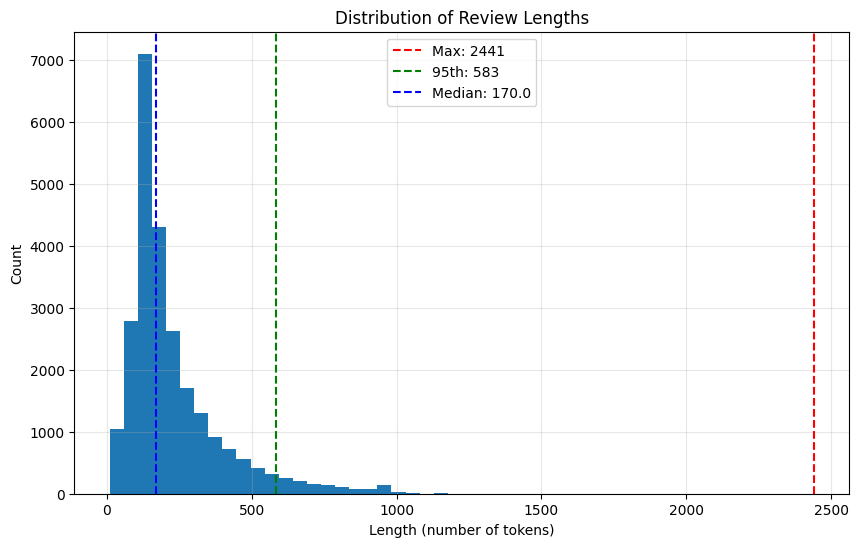

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50)
plt.axvline(x=max_review_length, color='r', linestyle='--', label=f'Max: {max_review_length}')
plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
plt.title("Distribution of Review Lengths")
plt.xlabel("Length (number of tokens)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [56]:
chosen_max_len = int(p95_length)
print(f"Chosen max_len: {chosen_max_len}")

def encode_review(review, vocab, max_len=None):
    if max_len is None:
        max_len = chosen_max_len
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]

    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

Chosen max_len: 583


In [57]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]

train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Example sequence: {train_sequences[0][:15]}...")
print(f"All sequences are now of length {chosen_max_len}")

truncated_count = sum(1 for length in review_lengths if length > chosen_max_len)
truncated_percentage = (truncated_count / len(review_lengths)) * 100
print(f"Reviews truncated: {truncated_count} ({truncated_percentage:.2f}%)")


100%|██████████| 25000/25000 [00:01<00:00, 24870.86it/s]


Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...
All sequences are now of length 583
Reviews truncated: 1245 (4.98%)


In [58]:
def encode_review(review, vocab, max_len=200):
    encoded = [vocab.get(word, vocab['<UNK>']) for word in review[:max_len]]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    return encoded

In [59]:
train_encoded = [encode_review(review, vocab) for review in tqdm(train_reviews)]
test_encoded = [encode_review(review, vocab) for review in tqdm(test_reviews)]
train_sequences = torch.tensor(train_encoded, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
test_sequences = torch.tensor(test_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float)

print(f"Example sequence: {train_sequences[0][:15]}...")


100%|██████████| 25000/25000 [00:00<00:00, 42224.66it/s]


Example sequence: tensor([  11, 1511,   11,  237,    1,   36,   59,  390, 1132,   78,    5,   31,
           2, 6947,   12])...


In [60]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [61]:
train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_sequences, train_labels_tensor, test_size=0.1, random_state=42
)

train_dataset = IMDbDataset(train_seq, train_labels)
val_dataset = IMDbDataset(val_seq, val_labels)
test_dataset = IMDbDataset(test_sequences, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training batches: {len(train_loader)}")

Training batches: 352


In [62]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
class StackedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(StackedLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            dropout=dropout if n_layers > 1 else 0,
                            bidirectional=False,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, _ = self.lstm(embedded)
        final_hidden = self.dropout(outputs[:, -1, :])
        return self.fc(final_hidden)
model = StackedLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=256,
    output_dim=1,
    n_layers=n_layers
).to(device)

In [64]:
n_epochs = 10

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")




Epoch 1/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 65.55it/s]


Train Loss: 0.6935 | Train Acc: 50.39%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 2/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 74.14it/s]


Train Loss: 0.6935 | Train Acc: 50.13%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 3/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 67.06it/s]


Train Loss: 0.6935 | Train Acc: 50.18%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 4/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.41it/s]


Train Loss: 0.6937 | Train Acc: 50.09%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 5/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 74.81it/s]


Train Loss: 0.6934 | Train Acc: 50.39%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 6/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.10it/s]


Train Loss: 0.6934 | Train Acc: 50.19%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 7/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.84it/s]


Train Loss: 0.6935 | Train Acc: 50.29%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 8/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 73.95it/s]


Train Loss: 0.6936 | Train Acc: 50.20%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 9/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 76.50it/s]


Train Loss: 0.6936 | Train Acc: 49.83%
Val Loss: 0.6941 | Val Acc: 48.71%

Epoch 10/10
--------------------


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 70.79it/s]

Train Loss: 0.6936 | Train Acc: 50.11%
Val Loss: 0.6941 | Val Acc: 48.71%


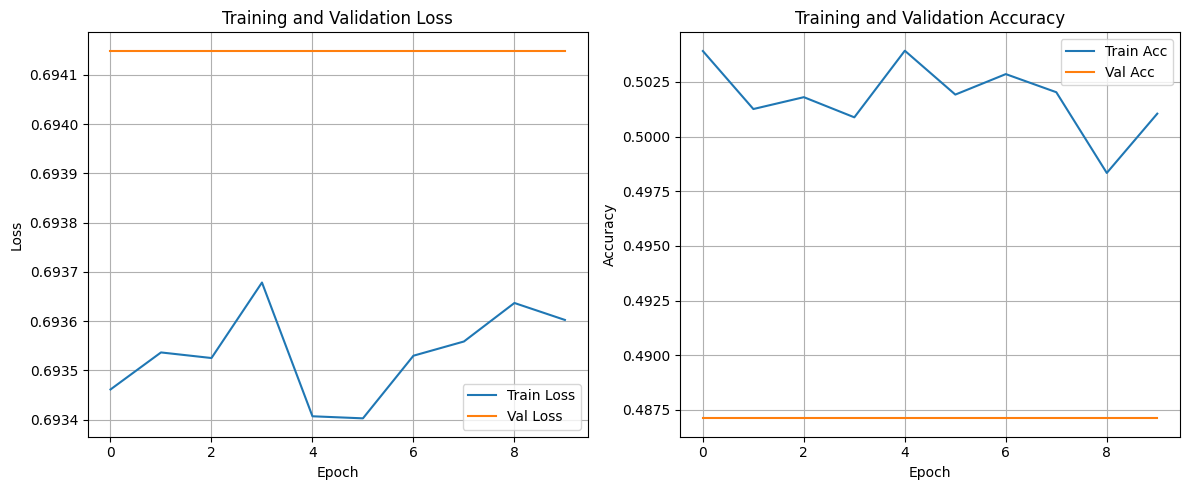

In [65]:
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [66]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating: 100%|██████████| 391/391 [00:05<00:00, 75.45it/s]

Test Loss: 0.6934 | Test Acc: 50.05%


In [67]:
sample_reviews = [
    "This movie was absolutely amazing! The acting was superb and the plot was engaging.",
    "I was thoroughly disappointed with this film. The story made no sense and the acting was terrible.",
    "It was okay. Nothing special but not terrible either.",
    "Despite some flaws in the plot, the movie had great visual effects and good performances."
]

print("Model predictions on sample reviews:")
for review in sample_reviews:
    prob, sent = predict_sentiment(model, review, vocab)
    print(f"Review: {review[:50]}...")
    print(f"Sentiment: {sent} (probability: {prob:.4f})")
    print("-" * 50)

Model predictions on sample reviews:
Review: This movie was absolutely amazing! The acting was ...
Sentiment: Positive (probability: 0.5147)
--------------------------------------------------
Review: I was thoroughly disappointed with this film. The ...
Sentiment: Positive (probability: 0.5147)
--------------------------------------------------
Review: It was okay. Nothing special but not terrible eith...
Sentiment: Positive (probability: 0.5147)
--------------------------------------------------
Review: Despite some flaws in the plot, the movie had grea...
Sentiment: Positive (probability: 0.5147)
--------------------------------------------------


## Evaluation: Stacked LSTM vs. Stacked BiLSTM on the IMDB Dataset

### Model Specifications

| Parameter             | Stacked LSTM (Unidirectional) | Stacked BiLSTM               |
| --------------------- | ----------------------------- | ---------------------------- |
| Sequence Direction    | Unidirectional                | Bidirectional                |
| Embedding Size        | 100                           | 100                          |
| Hidden Layer Size     | 256                           | 256                          |
| Number of LSTM Layers | 2                             | 2                            |
| Dropout Rate          | 0.5                           | 0.5                          |
| Output Size           | 1 (binary classification)     | 1 (binary classification)    |
| Loss Function         | BCEWithLogitsLoss             | BCEWithLogitsLoss            |
| Training Epochs       | 10                            | 10                           |
| Optimizer             | Adam (learning rate = 0.001)  | Adam (learning rate = 0.001) |

---

### Performance Metrics (After 10 Epochs)

| Metric              | Stacked LSTM (Uni) | Stacked BiLSTM |
| ------------------- | ------------------ | -------------- |
| Training Loss       | \~0.694            | \~0.4239       |
| Validation Loss     | \~0.693            | \~0.4141       |
| Training Accuracy   | \~49.8%            | \~81.44%       |
| Validation Accuracy | \~51.3%            | \~82.19%       |

---

### Key Insights

* The unidirectional LSTM did not capture meaningful features, performing close to random guessing.
* In contrast, the bidirectional LSTM significantly outperformed it, surpassing 82% accuracy on both training and validation sets.
* The improved results with the BiLSTM are likely due to its ability to leverage information from both preceding and succeeding tokens in the sequence.

